In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Descrição do experimento

##### O experimento é composto de:
- Genótipos: 10
- Repetição: 3
- Amostragem: 6
- Avaliadores: 3

Foram coletados de cada parcela uma amostra de frutos contendo **2 L** em que foram separados em subamostras, cada subamostra contem **300 ml** de frutos totalizando **6** amostras, foram analisados de cada parcela cerca de **1,8L** de frutos.
Para a analise dos frutos, 3 avaliadores contabilizaram de cada amostra o numero de frutos verdes (contendo os verdes e os verde-canas), maduros, e os passas(contendo os passas e secos).

O primeiro passo será verificar se os três avaliadore se diferenciam em questão a contagem dos frutos,

# Verificar diferença na contagem entre os avaliadores
O primeiro passo será verificar se os três avaliadores se diferenciam em questão a contagem dos frutos. 


In [3]:
data = pd.read_excel('C:\\Users\\Gustavo\\Projetos\\Maturação_Cafe\\maturacao.xlsx',sheet_name=0)
data.info()
display(data.head(5),data.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Trat       540 non-null    int64
 1   Rep        540 non-null    int64
 2   Avaliador  540 non-null    int64
 3   Amostra    540 non-null    int64
 4   Verde      540 non-null    int64
 5   Maduro     540 non-null    int64
 6   Seco       540 non-null    int64
 7   Total      540 non-null    int64
dtypes: int64(8)
memory usage: 33.9 KB


,Trat,Rep,Avaliador,Amostra,Verde,Maduro,Seco,Total
0,4,1,1,1,35,74,78,187
1,4,1,1,2,39,65,98,202
2,4,1,1,3,44,67,116,227
3,4,1,1,4,42,81,88,211
4,4,1,1,5,42,93,92,227


Trat          10
Rep            3
Avaliador      3
Amostra        6
Verde         92
Maduro        94
Seco         158
Total        121
dtype: int64

In [1]:
display(data.query('Trat == 10 & Rep == 1 & Amostra == 1'))

NameError: name 'data' is not defined

- Podemos verificar que há diferenças quanto a percepção de maturação dos diferentes avaliadores, portanto há utilização de um avaliador para a analise do caracter pode gerar erros.

Para determinar se houve diferença na contabilização dos frutos iremos calcular a diferença entre o maximo e o minimo do total de cada subamostra entre os três avaliadores.


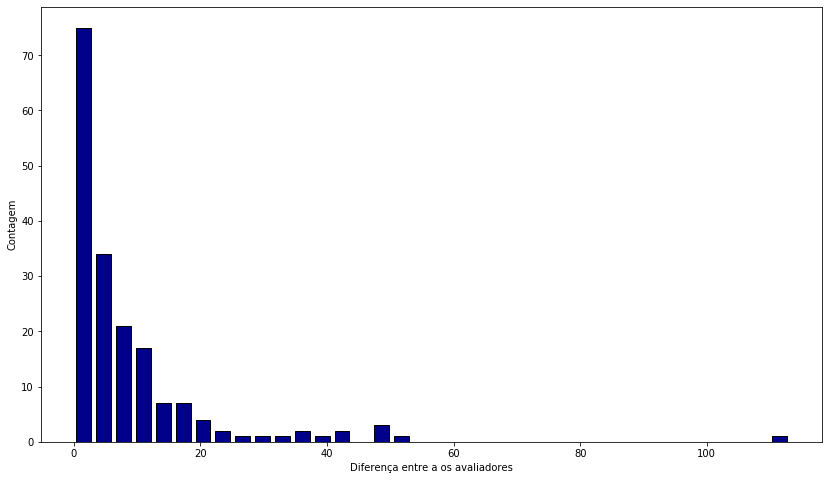

42.78 % dos avaliadores diferem quanto a contagem em ao menos 5
25.56 % dos avaliadores diferem quanto a contagem em ao menos 10
9.44 % dos avaliadores diferem quanto a contagem em ao menos 20
6.67 % dos avaliadores diferem quanto a contagem em ao menos 30


In [177]:
def diff(x):
    dif = np.max(x) - np.min(x)
    return dif

Diff = data.groupby(['Trat','Rep','Amostra'],as_index=False)['Total'].agg([np.max,np.min,diff]).reset_index()

_,ax = plt.subplots(figsize = (14,8))

ax.set(ylabel='Contagem')
sns.distplot(Diff['diff'],color='darkblue',kde= False,ax=ax,axlabel="Diferença entre a os avaliadores",
            hist_kws={"rwidth":0.75,'edgecolor':'black', 'alpha':1.0})
plt.show()

lista = [5,10,20,30]
for i in lista:
    al = round(((Diff[Diff['diff'] > i].shape[0])/(Diff.shape[0])*100),2)
    print(al,'% dos avaliadores diferem quanto a contagem em ao menos {}'.format(i))

- Os avaliadores divergem na contagem dos frutos, fato esse que nao poderia acontecer ja que todas as subparcelas possuem um numero de frutos fixo.

Ao realizar um subset nos dados podemos perceber que existem parcelas em que o total da contagem dos frutos se difere muito dependendo do avaliador chegando a diferenças de até **113 frutos.**

<span style="color:red ; font-size: 150%"> Tiramos algumas conclusões até aqui:<span>
- **Os avaliadores divergem quanto a percepção de maturação.**
- **Existe diferenças na contagem total dos frutos, um erro grave pois os frutos tem uma contagem fixa.**


# TAMANHO IDEAL DE AMOSTRA

 Para determinarmos o tamanho ideal de amostra iremos considerar a media dos tres avaliadores para cada parcela,posteriormente iremos somar as 6 subparcelas para trabalharmos com as parcelas .
 Com isso nos nao teremos mais as variaveis **Avaliadores** e **Amostra** pois a primeira foi considerado **media** e a segunda o **total**

In [149]:
data1 = data.groupby(['Trat','Rep','Amostra'],as_index=False).agg(np.mean).__round__(0)
data_agre = data1.groupby(['Trat','Rep'],as_index=False)[['Verde','Maduro','Seco','Total']].agg(np.sum)

# Tranformando as variaveis em seus respectivos tipos
data_agre[['Trat','Rep']] =data_agre[['Trat','Rep']].astype(object) 
data_agre[['Verde','Maduro','Seco']] = data_agre[['Verde','Maduro','Seco']].astype(int)

data_agre.head(5)

,Trat,Rep,Verde,Maduro,Seco,Total
0,4,1,291,408,556,1254.0
1,4,2,357,513,222,1092.0
2,4,3,268,484,512,1264.0
3,8,1,152,405,444,1000.0
4,8,2,117,441,463,1021.0


Para verificarmos qual o tamanho de amostra ideal,o **primeiro passo** será realizar 100 reamostragens para cada parcela e para cada tamanho amostral nos dados variando as amostras nos seguintes intervalos 
**20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800** computando a porcentagem de cada estagio de maturação.

In [154]:
n_amostras = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]

novo= pd.DataFrame(columns = ['Verde','Vermelho','Seco','Tratamento','Repeticao','Tamanho_amostral'])


for z in data_agre.index: 
    variavel = list(data_agre.iloc[z,2:5])
    
    trat = data_agre.iloc[z,:]['Trat']
    rep = data_agre.iloc[z,:]['Rep']
       
    verde = list(('Verde',) * variavel[0])
    vermelho = list(('Vermelho',) * variavel[1])
    seco = list(('Seco',)*variavel[2])
    listas = verde + vermelho + seco
    np.random.shuffle(listas)      
    
    for a in n_amostras:##(10,20,...500)
        lista_vermelho = []
        lista_verde = []
        lista_seco = []
        for i in range(100):
            bs_sample = np.random.choice(listas, size=a)
            p_verm = (bs_sample == 'Vermelho').sum()/len(bs_sample)
            p_verde = (bs_sample == 'Verde').sum()/len(bs_sample)
            p_seco = (bs_sample == 'Seco').sum()/len(bs_sample)
            lista_vermelho.append(p_verm)
            lista_verde.append(p_verde)
            lista_seco.append(p_seco)
            if i == 99:
                tra = list((trat,)*100)
                tam = list((a,)*100)
                repe = list((rep,)*100)
                #Rep = list(())
                df = pd.DataFrame(list(zip(lista_verde,lista_vermelho,lista_seco,tra,repe,tam)),columns =['Verde','Vermelho','Seco','Tratamento','Repeticao','Tamanho_amostral'])
                novo = pd.concat([novo,df])
novo.sample(10)        

,Verde,Vermelho,Seco,Tratamento,Repeticao,Tamanho_amostral
35,0.120000,0.454286,0.425714,8,3,350
27,0.163636,0.389091,0.447273,9,1,550
76,0.206667,0.390000,0.403333,4,3,300
63,0.187500,0.362500,0.450000,24,2,80
68,0.260000,0.405000,0.335000,9,3,200
6,0.130000,0.455000,0.415000,4,3,200
26,0.137143,0.334286,0.528571,24,2,350
4,0.100000,0.450000,0.450000,4,3,20
65,0.355556,0.402222,0.242222,10,1,450
83,0.118333,0.415000,0.466667,23,3,600


Os dados adivindas dos 10 genotipos * 3 Repetições * 100 subamostras * 22 tamanhos amostrais geraram no total de 66000 linhas.
O proximo passo da analise é computar os parametros **media,herdabilidade e CVe** para os 3 estagios de maturação, tendo uma confiabilidade de 95%. 


In [195]:
resu = pd.DataFrame(columns =['Minimo_2.5 CV','Maximo_97.5 CV','Minimo_2.5 H2','Maximo_97.5 H2','Tamanho_amostral','Cor'])
lista2 = ['Verde','Vermelho','Seco']


for u in lista2:
    for a in novo.Tamanho_amostral.unique():
        CV= []
        h2 = []
        med = []
        for i in range(100):
            df= pd.DataFrame(columns = ['Verde','Vermelho','Seco','Tratamento','Repeticao','Tamanho_amostral'])
            for x in novo.Repeticao.unique():
                for w in novo.Tratamento.unique():
                    amostra = novo.query('Tamanho_amostral == {} & Tratamento == {} & Repeticao == {}'.format(a,w,x))
                    amostra = amostra.sample(axis=0)
                    df = pd.concat([df,amostra])
                    if len(df) == 30:
                        modelomanual = ols('{} ~ C(Tratamento) + C(Repeticao)'.format(u), data=df).fit()
                        aov_table = sm.stats.anova_lm(modelomanual, typ=1)
                        vargen =(((aov_table.iloc[0,2]) - (aov_table.iloc[2,2]))/3)
                        varerr = aov_table.iloc[0,2]
                        qme = (aov_table.iloc[2,2])**0.5
                        media = df[f'{u}'].mean()
                        med.append(media) 
                        cv = ((qme/media)*100).__round__(2)
                        CV.append(cv)
                        H2= vargen/(vargen+(varerr/3))
                        h2.append(H2)
                        
                        if i == 99:
                            c,d = list(np.percentile(CV,[2.5, 97.5]))
                            v,s = list(np.percentile(h2,[2.5, 97.5]))
                            x,y = list(np.percentile(med,[2.5, 97.5]))
                            teste = [x,y,c,d,v,s,a,u]
                            vao = pd.DataFrame([teste],columns =['Minimo_2.5 Media','Maximo_97.5 Media','Minimo_2.5 CV','Maximo_97.5 CV','Minimo_2.5 H2','Maximo_97.5 H2','Tamanho_amostral','Cor'])
                            resu = pd.concat([resu,vao])   
                        
resu.head()

,Minimo_2.5 CV,Maximo_97.5 CV,Minimo_2.5 H2,Maximo_97.5 H2,Tamanho_amostral,Cor,Minimo_2.5 Media,Maximo_97.5 Media
0,37.57500,64.46425,0.221507,0.456705,20,Verde,0.162375,0.220083
0,30.66525,53.78200,0.366696,0.474116,40,Verde,0.172417,0.208333
0,28.91425,45.69375,0.396997,0.472732,60,Verde,0.173889,0.206986
0,25.59675,46.19650,0.399705,0.476534,80,Verde,0.176250,0.206052
0,26.75450,40.29250,0.431084,0.475427,100,Verde,0.180000,0.203717


In [163]:
resu = pd.read_csv('Parametros.csv')
resu.sample(5)

,Unnamed: 0,Minimo_2.5 CV,Maximo_97.5 CV,Minimo_2.5 H2,Maximo_97.5 H2,Tamanho_amostral,Cor,Minimo_2.5 Media,Maximo_97.5 Media
61,0,25.78475,29.32525,0.394402,0.430008,600,Seco,0.437021,0.448400
53,0,25.31325,31.65350,0.370006,0.437163,200,Seco,0.426721,0.455367
4,0,26.75450,40.29250,0.431084,0.475427,100,Verde,0.180000,0.203717
28,0,26.40700,34.23400,-3.295484,0.298449,140,Vermelho,0.350702,0.379661
6,0,25.50300,40.64875,0.417031,0.476829,140,Verde,0.180815,0.205512


Percebemos que existe algumas herdabilidades calculadas menores que zero e outras maiores que 1, portanto iremos corrigir os dados para que quando negativo se tornar zero e quando maior que 1 se tornar 1.

In [164]:
resu
for index, row in resu.iterrows():
    if row['Minimo_2.5 H2'] < 0:
        resu['Minimo_2.5 H2'][index] = 0
    else:
        pass
    if row['Maximo_97.5 H2'] > 1:
         resu['Maximo_97.5 H2'][index] = 1
    else:
        pass
resu.sample(10)   

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Unnamed: 0,Minimo_2.5 CV,Maximo_97.5 CV,Minimo_2.5 H2,Maximo_97.5 H2,Tamanho_amostral,Cor,Minimo_2.5 Media,Maximo_97.5 Media
35,0,26.99550,31.54025,0.000000,0.192183,400,Vermelho,0.359269,0.374210
47,0,25.27275,34.63100,0.328810,0.432174,80,Seco,0.420115,0.457938
41,0,26.78475,31.48625,0.000000,0.204021,700,Vermelho,0.360561,0.372739
37,0,27.03325,31.69200,0.000000,0.199175,500,Vermelho,0.360152,0.373630
21,0,25.24475,31.07525,0.460472,0.476838,800,Verde,0.186746,0.195083
31,0,26.22950,33.34250,0.000000,0.270709,200,Vermelho,0.356246,0.379850
46,0,25.94700,37.34125,0.323719,0.442453,60,Seco,0.421111,0.462806
17,0,25.22375,32.32350,0.457533,0.476761,600,Verde,0.185717,0.195032
33,0,27.52850,32.77150,0.000000,0.244459,300,Vermelho,0.359275,0.376958
16,0,24.94075,32.76100,0.453948,0.477189,550,Verde,0.184112,0.194855


In [170]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import Panel, Tabs
from bokeh.plotting import ColumnDataSource
from bokeh.layouts import row,column
output_notebook()

resu['Tamanho_amostral'] = resu['Tamanho_amostral'].astype(int)

verde = resu[resu['Cor']=='Verde']
verm = resu[resu['Cor']=='Vermelho']
seco = resu[resu['Cor']=='Seco']

source = ColumnDataSource(verde)
source1 = ColumnDataSource(verm)
source2 = ColumnDataSource(seco)

p = figure(x_axis_label='Tamanho Amostral',y_axis_label='h2')
p.varea(x='Tamanho_amostral',y1 ='Minimo_2.5 H2',y2 ='Maximo_97.5 H2',source=source1,color='red')
p.xaxis.ticker = np.arange(0,850,step=50)
p.xgrid.minor_grid_line_alpha = 0.5


p1=figure(x_axis_label='Tamanho Amostral',y_axis_label='h2')
p1.varea(x='Tamanho_amostral',y1 ='Minimo_2.5 H2',y2 ='Maximo_97.5 H2',source=source,color='green')
p1.xaxis.ticker = np.arange(0,850,step=50)

p2=figure(x_axis_label='Tamanho Amostral',y_axis_label='h²')
p2.varea(x='Tamanho_amostral',y1 ='Minimo_2.5 H2',y2 ='Maximo_97.5 H2',source=source2,color='black')
p2.xaxis.ticker = np.arange(0,850,step=50)

first=Panel(child = p,title='Vermelho h2')
Second=Panel(child = p1,title='Verde h2')
Third =Panel(child = p2,title='Seco h2')

tabs = Tabs(tabs=[first,Second,Third])


####CV
p3 = figure(x_axis_label='Tamanho Amostral',y_axis_label='CV')
p3.varea(x='Tamanho_amostral',y1 ='Minimo_2.5 CV',y2 ='Maximo_97.5 CV',source=source1,color='red')
p3.xaxis.ticker = np.arange(0,850,step=50)
p3.xgrid.minor_grid_line_alpha = 0.5


p4=figure(x_axis_label='Tamanho Amostral',y_axis_label='CV')
p4.varea(x='Tamanho_amostral',y1 ='Minimo_2.5 CV',y2 ='Maximo_97.5 CV',source=source,color='green')
p4.xaxis.ticker = np.arange(0,850,step=50)

p5=figure(x_axis_label='Tamanho Amostral',y_axis_label='CV')
p5.varea(x='Tamanho_amostral',y1 ='Minimo_2.5 CV',y2 ='Maximo_97.5 CV',source=source2,color='black')
p5.xaxis.ticker = np.arange(0,850,step=50)

prim=Panel(child = p3,title='Vermelho CV')
Segu=Panel(child = p4,title='Verde CV')
Terc =Panel(child = p5,title='Seco CV')

#####Media

p6 = figure(x_axis_label='Tamanho Amostral',y_axis_label='Media')
p6.varea(x='Tamanho_amostral',y1 ='Minimo_2.5 Media',y2 ='Maximo_97.5 Media',source=source1,color='red')
p6.xaxis.ticker = np.arange(0,850,step=50)
p6.xgrid.minor_grid_line_alpha = 0.5


p7=figure(x_axis_label='Tamanho Amostral',y_axis_label='Media')
p7.varea(x='Tamanho_amostral',y1 ='Minimo_2.5 Media',y2 ='Maximo_97.5 Media',source=source,color='green')
p7.xaxis.ticker = np.arange(0,850,step=50)

p8=figure(x_axis_label='Tamanho Amostral',y_axis_label='Media')
p8.varea(x='Tamanho_amostral',y1 ='Minimo_2.5 Media',y2 ='Maximo_97.5 Media',source=source2,color='black')
p8.xaxis.ticker = np.arange(0,850,step=50)

f=Panel(child = p6,title='Vermelho Media')
s=Panel(child = p7,title='Verde Media')
t =Panel(child = p8,title='Seco Media')


tabs2 = Tabs(tabs=[f,s,t])


test = column(tabs,tabs1,tabs2)


show(test)

Loading BokehJS ...

<span style="color:black ; font-size: 150%">Podemos perceber que existe uma tendência dos dados em começar a variar menos quando passamos de uma amostra de 300 frutos.
Portanto podemos dizer que até o momento o tamanho de amostra ideal é de 300 Frutos.<span>